In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
# select the data
def select_data(data, start=2016, end=2024, columns=None):
    # convert the data to a pandas dataframe
    data['Date'] = pd.to_datetime(data['Date'])
    # create a mask for the data
    mask = (data['Date'].dt.year >= start) & (data['Date'].dt.year <= end)
    # select the data
    data = data.loc[mask]
    if columns is not None:
        data = data[columns]
    else:
        # drop the date column
        data = data.drop(columns='Date')
    return data

In [3]:
def prepare_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, :])
    return np.array(X), np.array(Y)

In [4]:
def create_scaler(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    return scaler, dataset 
def to_scalar(scaler, data):
    return scaler.transform(data)

In [5]:
def create_model(dataset, look_back=1, epochs=100, batch_size=1, verbose=1):
    X, Y = prepare_dataset(dataset, look_back)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
    Y = np.reshape(Y, (Y.shape[0], Y.shape[1]))
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.1))
    model.add(LSTM(units=50))
    model.add(Dense(X.shape[2]))  # Assuming single feature for simplicity
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    return model

In [6]:
# declare the path of the data
path_to_data = "data/data_mean.csv"

# load the data
# import pandas as pd
data = pd.read_csv(path_to_data)

col=['Rice', 'Wheat', 'Atta (Wheat)', 'Gram Dal', 'Tur/Arhar Dal']

# select the desired data
req_data = select_data(data=data, start=2022, end=2024, columns=col)
print(req_data.shape)

(979, 5)


In [7]:
# split the data into training and testing
train_size = int(len(req_data) * 0.80)
test_size = len(req_data) - train_size
train, test = req_data[0:train_size], req_data[train_size:len(req_data)]

In [8]:
# scale the data
scaler, train_scaler = create_scaler(train) # scaled_data is a numpy array

In [9]:
# set the look back
look_back = 7
# create the model
myModel = create_model(train_scaler, look_back, epochs=50, batch_size=1, verbose=1)

Epoch 1/50


c:\Users\krish\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0221
Epoch 2/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0024
Epoch 3/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0022
Epoch 4/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0019
Epoch 5/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0020
Epoch 6/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0017
Epoch 7/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0018
Epoch 8/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0018
Epoch 9/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0020
Epoch 10/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0016
Epoch 11/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0015
Epoch 12/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0014
Epoch 13/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0016
Epoch 14/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0015
Epoch 15/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0013


In [10]:
# prepare test data
# convert to scaler
test_scalar = scaler.transform(test)
# split features and outcome
x_test, y_test = prepare_dataset(test_scalar, look_back)

In [11]:
x_train, y_train = prepare_dataset(train_scaler, look_back)

In [12]:
# predict the results
test_pred_scalar = myModel.predict(x_test)
train_pred_scalar = myModel.predict(x_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [13]:
# invert the predictions
test_pred = scaler.inverse_transform(test_pred_scalar)
train_pred = scaler.inverse_transform(train_pred_scalar)

# invert the actual values
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [14]:
# print the results dataframes first 5 rows
print(pd.DataFrame(train_pred).head())
print(pd.DataFrame(y_train).head())
print(pd.DataFrame(test_pred).head())
print(pd.DataFrame(y_test).head())

           0          1          2          3           4
0  46.996727  37.087868  41.661156  78.989510  104.917503
1  46.609482  36.835682  41.474846  78.204002  104.328011
2  45.940887  36.235931  40.941833  77.107132  103.620041
3  46.236088  36.968288  41.511608  78.118805  104.633110
4  46.376247  37.052402  41.769524  78.174713  104.964020
       0      1      2      3       4
0  46.88  37.00  43.38  78.00  105.25
1  43.33  34.33  39.00  74.00  100.67
2  47.00  37.22  42.22  78.56  105.22
3  47.11  37.22  42.22  78.56  105.22
4  46.78  37.22  42.22  78.33  105.44
           0          1          2          3           4
0  62.077488  45.318306  53.699604  86.975487  162.660812
1  62.085251  45.335140  53.703144  87.054039  162.532104
2  62.028385  45.309616  53.731346  86.942863  162.888214
3  62.015816  45.283520  53.727482  86.755196  163.088303
4  62.026604  45.288361  53.731644  86.773689  163.211136
       0      1      2      3       4
0  62.12  45.88  52.97  87.09  162.85


In [15]:
# print the shape of the data
print(y_test.shape)
print(test_pred.shape)
print(y_train.shape)
print(train_pred.shape)

(189, 5)
(189, 5)
(776, 5)
(776, 5)


In [16]:
# print shape of test and train data
print(test.shape)
print(train.shape)

(196, 5)
(783, 5)


In [17]:
myScaler = scaler
# myModel


In [18]:
print(data.head())

   Day  Month  Year  Rice  Wheat  Atta (Wheat)  Gram Dal  Tur/Arhar Dal  \
0    1      1  2016  29.5  30.50         26.67     70.50          155.0   
1    2      1  2016  29.6  31.40         27.50     71.40          154.6   
2    3      1  2016  29.6  31.40         27.50     71.40          154.0   
3    4      1  2016  29.6  31.40         27.50     71.40          151.6   
4    5      1  2016  29.5  31.75         27.50     71.75          151.5   

        Date  
0 2016-01-01  
1 2016-01-02  
2 2016-01-03  
3 2016-01-04  
4 2016-01-05  


In [24]:
def predict_date(data, date, model, scaler, look_back):
    # Convert the date to datetime
    date = pd.to_datetime(date)
    data['Date'] = pd.to_datetime(data['Date'])
    cols = ['Rice', 'Wheat', 'Atta (Wheat)', 'Gram Dal', 'Tur/Arhar Dal']

    # Get the start and end date of the data
    start_date = data['Date'].min()
    end_date = data['Date'].max()

    # If the date is within the historical data
    if start_date <= date <= end_date:
        return data[data['Date'] == date][cols]
    elif date > end_date:
        # Initialize a list to store predicted values
        predictions = []
        current_date = end_date + pd.DateOffset(days=1)
        last_data_scaled = scaler.transform(data.tail(look_back)[cols])
        last_data_scaled = last_data_scaled.reshape((1, look_back, len(cols)))

        while current_date <= date:
            # Predict the next day's values
            predicted_scaled = model.predict(last_data_scaled, verbose=0)
            predictions.append(predicted_scaled[0])

            # Update the last_data_scaled for the next prediction
            new_data_scaled = np.append(last_data_scaled[:, 1:, :], predicted_scaled[:, np.newaxis, :], axis=1)
            last_data_scaled = new_data_scaled

            current_date += pd.DateOffset(days=1)

        # Convert the last prediction to original scale
        predicted_values = scaler.inverse_transform(predictions[-1].reshape(1, -1))

        return pd.DataFrame(predicted_values, columns=cols)
    else:
        return "Date is before the available data range."

In [39]:
# predict the price of the commodities on 2024-01-31
date = '2024-12-31'
result = predict_date(data, date, myModel, myScaler, look_back)
print(result)

        Rice     Wheat  Atta (Wheat)  Gram Dal  Tur/Arhar Dal
0  57.290874  44.30661     53.642487  88.49823     180.015778


In [43]:
# print result
print(result.map("{:.2f}".format))

    Rice  Wheat Atta (Wheat) Gram Dal Tur/Arhar Dal
0  57.29  44.31        53.64    88.50        180.02


In [33]:
import joblib
from keras.models import save_model

# Save the model
model_path = 'myModel.keras'
save_model(myModel, model_path)
print(f"Model saved at {model_path}")

# Save the scaler
scaler_path = 'scaler.pkl'
joblib.dump(myScaler, scaler_path)
print(f"Scaler saved at {scaler_path}")


Model saved at myModel.keras
Scaler saved at scaler.pkl


In [21]:
# import the evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# calculate the evaluation metrics for train data
train_mae = mean_absolute_error(y_train, train_pred)
train_mse = mean_squared_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

# calculate the evaluation metrics for test data
test_mae = mean_absolute_error(y_test, test_pred)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

# create a dataframe to display the results
results = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Mean Absolute Error': [train_mae, test_mae],
    'Mean Squared Error': [train_mse, test_mse],
    'R2 Score': [train_r2, test_r2]
})

# print the results
print(results)


  Dataset  Mean Absolute Error  Mean Squared Error  R2 Score
0   Train             0.556351            0.721286  0.984431
1    Test             2.383699           14.382720 -0.142065


In [26]:
# create a function to calculate the accuracy
def calculate_accuracy(y_true, y_pred):
    # calculate the percentage error
    error = np.abs((y_true - y_pred) / y_true) * 100
    # calculate the accuracy
    accuracy = 100 - np.mean(error, axis=0)
    return accuracy

# Calculate accuracy for train data
train_accuracy = calculate_accuracy(y_train, train_pred)
print("Training Accuracy:", train_accuracy)

# Calculate accuracy for test data
test_accuracy = calculate_accuracy(y_test, test_pred)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: [99.21588706 99.38019086 99.04775276 99.48928158 99.05696831]
Testing Accuracy: [98.6697351  98.88066575 98.67516268 95.78862207 96.63003264]


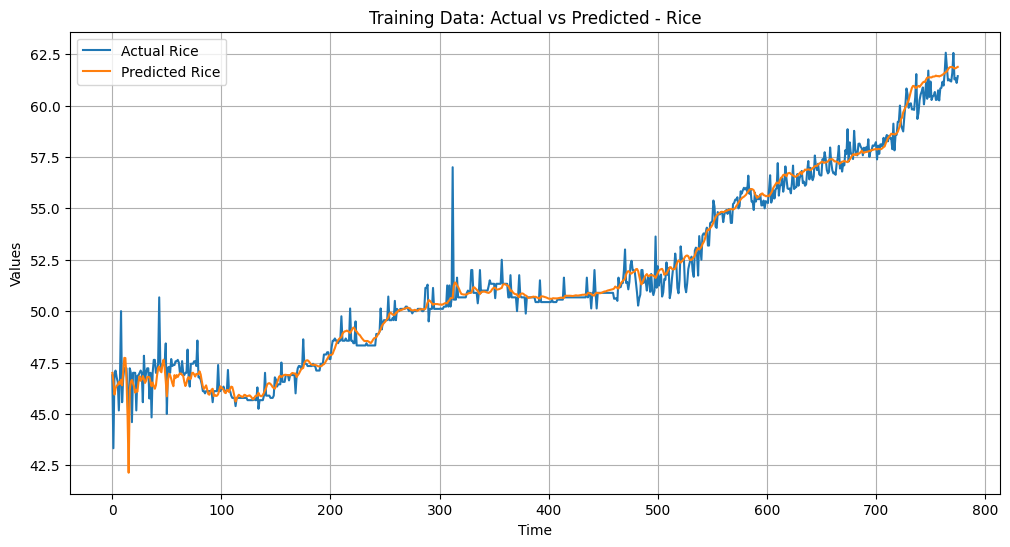

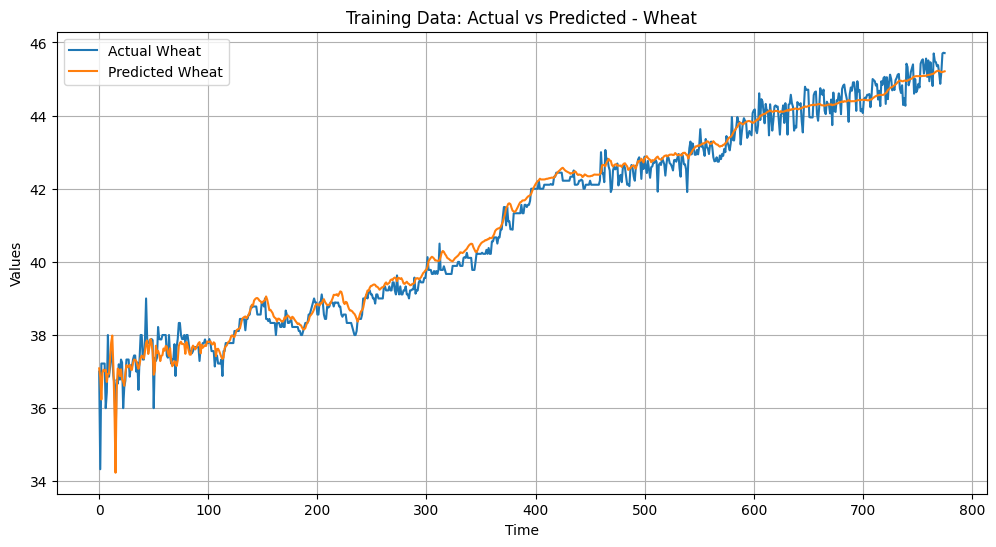

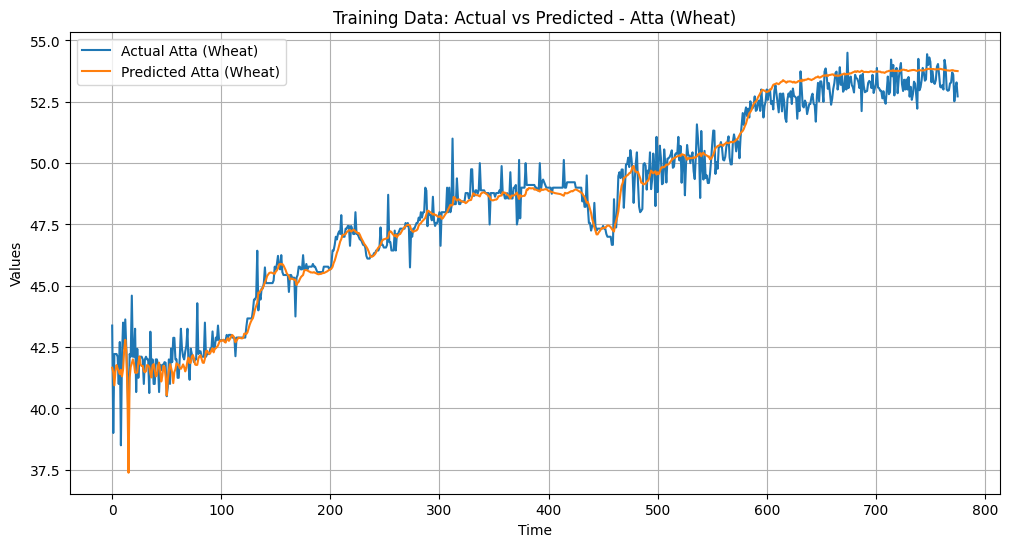

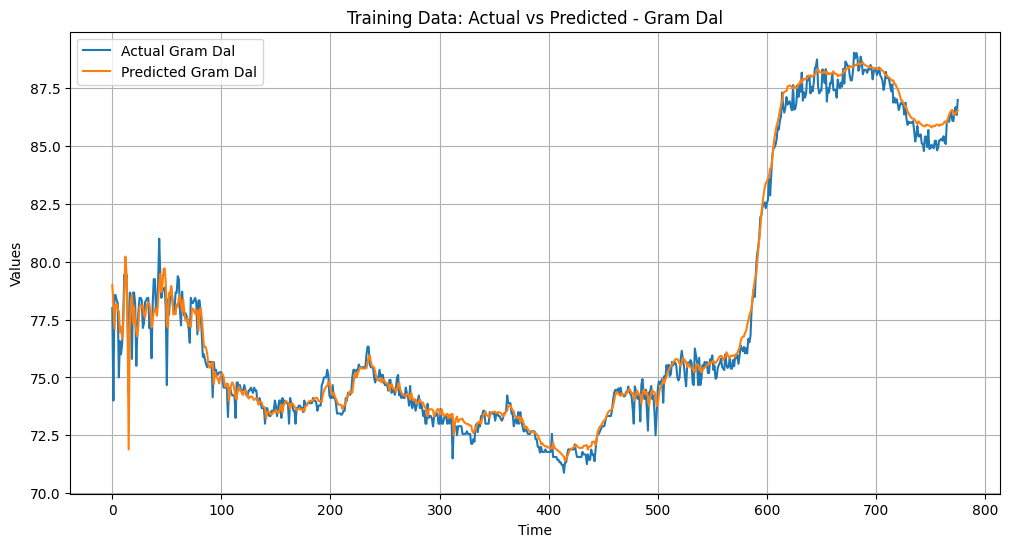

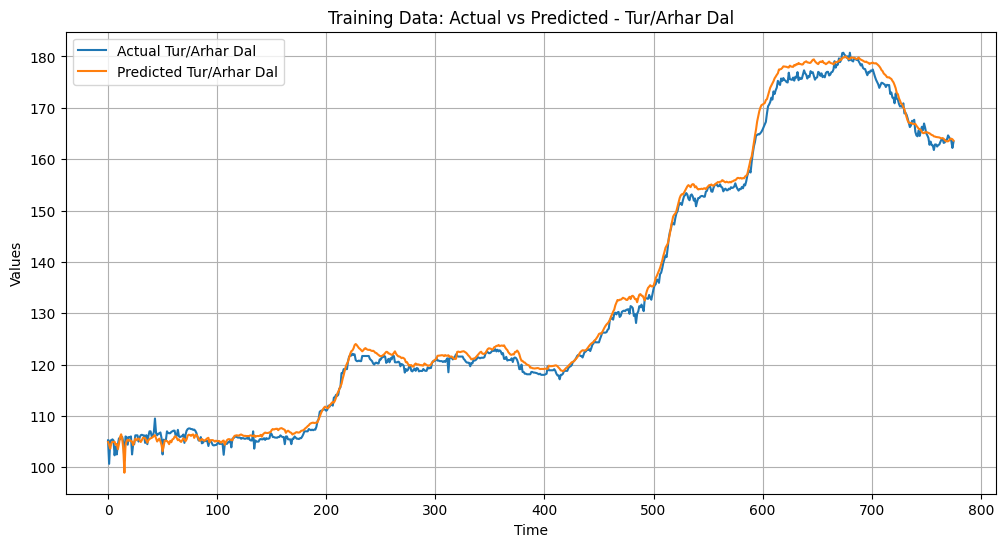

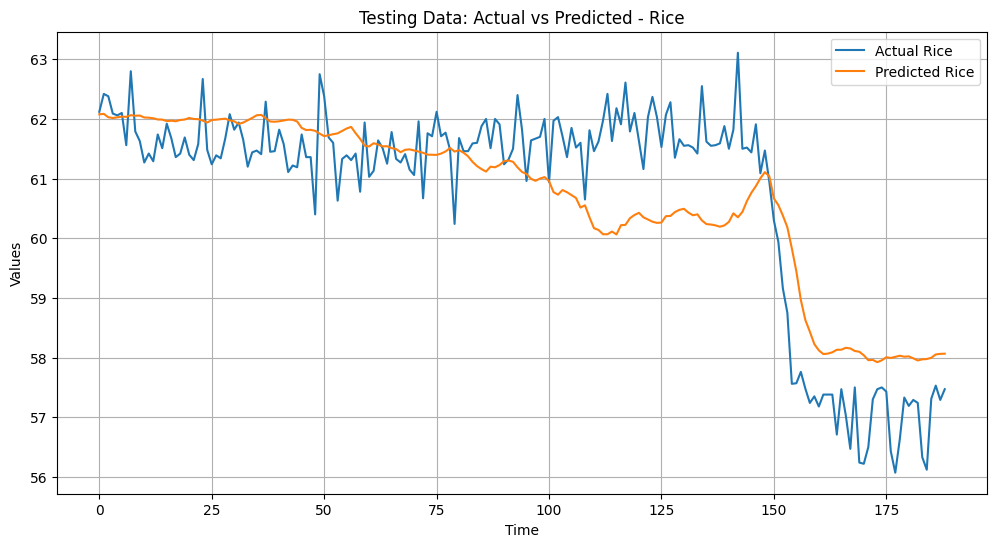

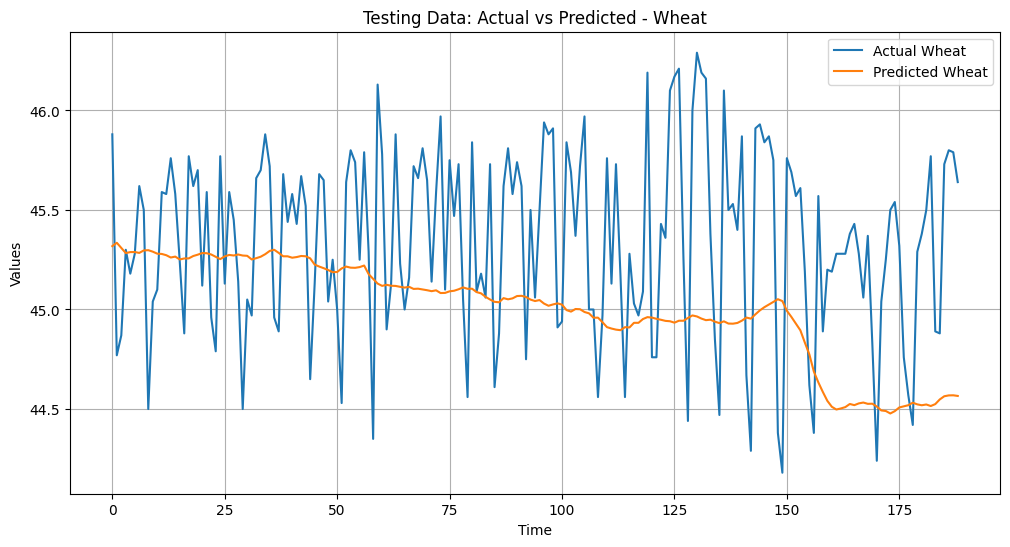

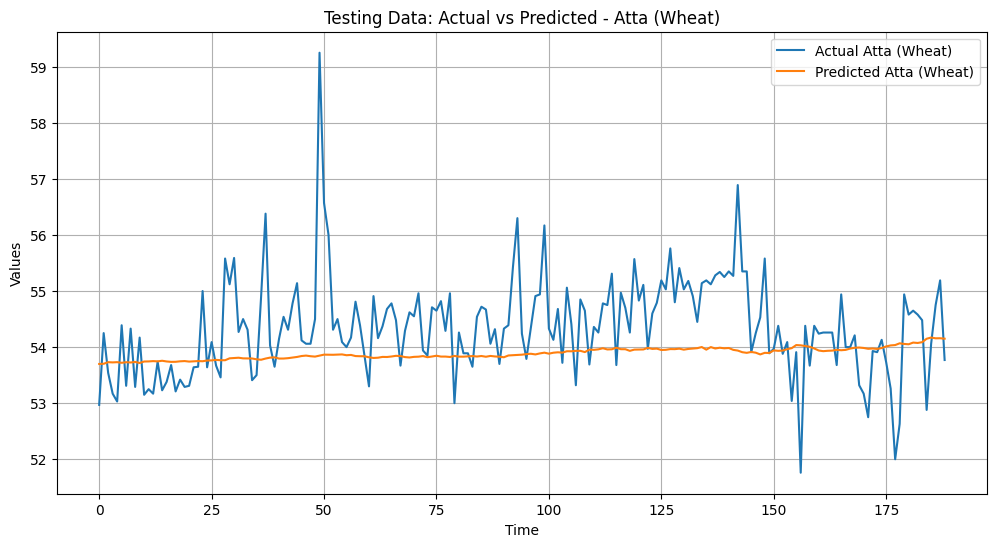

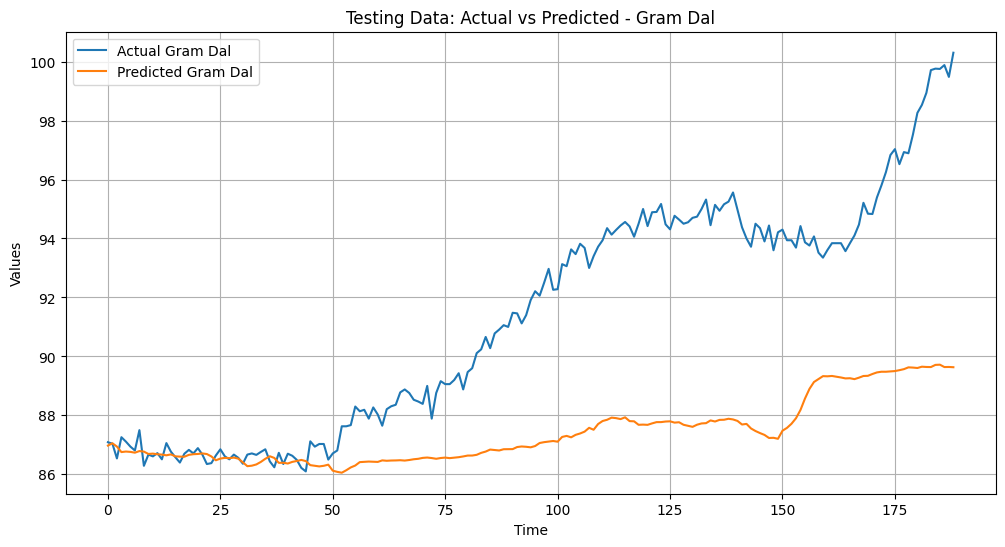

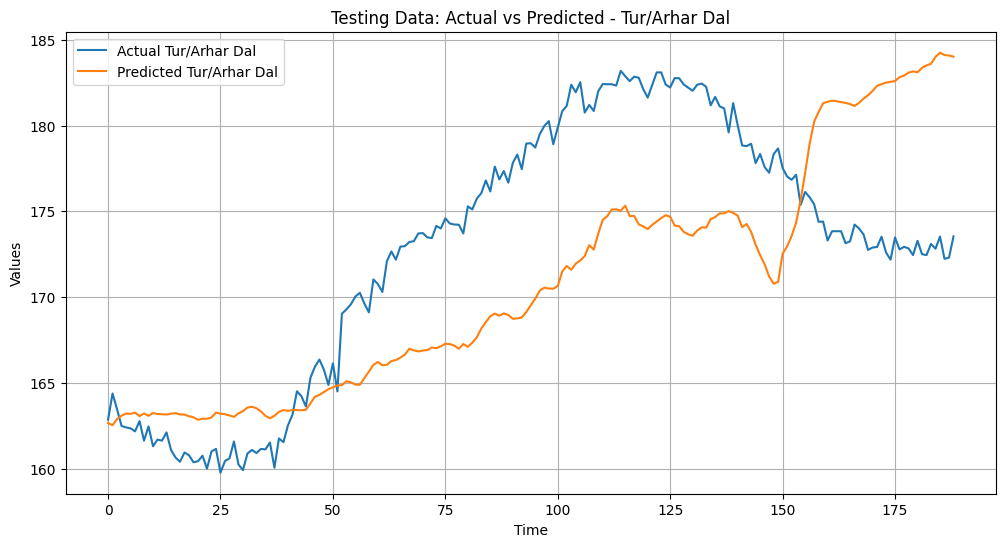

In [23]:
# plot the predictions
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, columns, title):
    for i, column in enumerate(columns):
        plt.figure(figsize=(12, 6))
        plt.plot(y_true[:, i], label=f'Actual {column}')
        plt.plot(y_pred[:, i], label=f'Predicted {column}')
        plt.title(f'{title} - {column}')
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.legend()
        plt.grid(True)
        plt.show()

# column names
columns = ['Rice', 'Wheat', 'Atta (Wheat)', 'Gram Dal', 'Tur/Arhar Dal']

# plot y_train and train_pred
plot_predictions(y_train, train_pred, columns, 'Training Data: Actual vs Predicted')

# plot y_test and test_pred
plot_predictions(y_test, test_pred, columns, 'Testing Data: Actual vs Predicted')
